In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score


In [2]:
df = pd.read_csv('./heart.csv')

In [3]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Attribute Information
Age: age of the patient [years]
Sex: sex of the patient [M: Male, F: Female]
ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
RestingBP: resting blood pressure [mm Hg]
Cholesterol: serum cholesterol [mm/dl]
FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
Oldpeak: oldpeak = ST [Numeric value measured in depression]
ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
HeartDisease: output class [1: heart disease, 0: Normal]

### 1. Предварительный анализ данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
# поиск дубликатов
df.duplicated().sum()

0

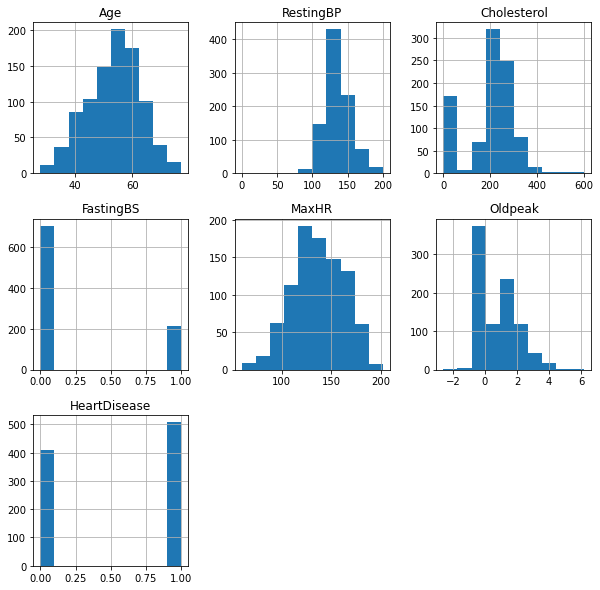

In [6]:
df.hist(figsize = (10,10));

In [7]:
# Расчет количества отрицательных значений в столбце 'Oldpeak'
df[df['Oldpeak']<0].Oldpeak.count()


13

In [8]:
# Расчет баланса классов таргета.
df.HeartDisease.value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

#### Выводы.
* Аномальных значений в данных не обнаружено.
* Необходимо уточнить корректность отрицательных значений в столбце 'Oldpeak' (13 шт.)
* Дубликаты отсутствуют. Пропуски в данных отсутствуют.
* Баланс классов таргета удовлетворительный для дальнейшенго обучения модели (55/45).

In [9]:
# Приведение текстовых данных датасета к числовым с помощью метода get_dummies.
data = pd.get_dummies(df, drop_first=True)

In [10]:
data

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,1,0,0,1,1,0,0,1,0
914,68,144,193,1,141,3.4,1,1,0,0,0,1,0,0,1,0
915,57,130,131,0,115,1.2,1,1,0,0,0,1,0,1,1,0
916,57,130,236,0,174,0.0,1,0,1,0,0,0,0,0,1,0


In [11]:
# Стандартизация данных методом StandardScaler
scaler = StandardScaler()

data[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']] = scaler.fit_transform(
    data[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']]
)

In [12]:
data

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,-0.551341,1.382928,-0.832432,0,1,1,0,0,1,0,0,0,1
1,-0.478484,1.491752,-0.171961,-0.551341,0.754157,0.105664,1,0,0,1,0,1,0,0,1,0
2,-1.751359,-0.129513,0.770188,-0.551341,-1.525138,-0.832432,0,1,1,0,0,0,1,0,0,1
3,-0.584556,0.302825,0.139040,-0.551341,-1.132156,0.574711,1,0,0,0,0,1,0,1,1,0
4,0.051881,0.951331,-0.034755,-0.551341,-0.581981,-0.832432,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,-1.210356,0.596393,-0.551341,-0.188999,0.293283,1,1,0,0,1,1,0,0,1,0
914,1.536902,0.627078,-0.053049,1.813758,0.164684,2.357094,1,1,0,0,0,1,0,0,1,0
915,0.370100,-0.129513,-0.620168,-0.551341,-0.857069,0.293283,1,1,0,0,0,1,0,1,1,0
916,0.370100,-0.129513,0.340275,-0.551341,1.461525,-0.832432,1,0,1,0,0,0,0,0,1,0


In [13]:
# Разделение датасета на обучающую и валидационную выборки.
features = data.drop('HeartDisease', axis=1)
target = data.HeartDisease
x_train, x_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.25, random_state=123)

In [14]:
x_train


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
102,-1.433140,0.951331,1.767219,-0.551341,-0.267596,1.043759,0,0,0,0,1,0,0,1,0
692,-1.539213,-2.075031,0.001833,-0.551341,1.658016,-0.832432,0,0,1,0,1,0,0,0,1
842,-1.114921,-0.021428,1.300718,1.813758,-0.031807,1.981855,0,0,0,0,0,0,1,1,0
275,0.582246,2.572596,0.129892,-0.551341,-1.446542,-0.832432,1,0,1,0,1,0,0,0,1
273,0.157954,-0.669935,0.193922,-0.551341,-0.110403,-0.832432,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.264027,-0.669935,-1.040933,-0.551341,0.125386,-0.832432,1,0,0,0,1,0,0,0,1
322,-1.645286,-1.480567,-1.818435,1.813758,1.147139,1.794236,0,0,0,0,1,0,0,0,1
382,-1.114921,-0.940145,-1.818435,-0.551341,0.321877,1.043759,1,0,0,0,1,0,1,1,0
365,1.112610,3.653439,-1.818435,-0.551341,0.125386,0.105664,0,0,0,0,1,0,1,1,0


In [15]:
y_train.mean()

0.5494186046511628

### 2. Обучение модели "случайный лес" 

In [16]:
# Создание экземпляра класса RandomForestClassifier и словаря гиперпараметров.
rf_clf = RandomForestClassifier(random_state=123, n_jobs=-1, class_weight='balanced')
params = {
    'n_estimators' : [10, 50, 100, 150, 200, 250, 300] + [i for i in range(205, 215, 1)],
    'max_depth' : [i for i in range(3, 11)] 
}

In [17]:
%%time
# Обучение модели и подбор гиперпараметров методом GridSeachCV 
model = GridSearchCV(
    estimator=rf_clf,
    param_grid=params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
    )

model.fit(x_train, y_train)
print('model is fit!!!')

model is fit!!!
CPU times: total: 2.7 s
Wall time: 1min 6s


In [18]:
# Результат лучшей модели после обучения.
print(model.best_estimator_)
print( 'roc_score =', model.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=210,
                       n_jobs=-1, random_state=123)
roc_score = 0.9328217317487267


In [19]:
best_model = model.best_estimator_
print(best_model.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=210,
                       n_jobs=-1, random_state=123)>


In [20]:
%%time
# Проверка качества модели методом cross_val_score.
cv_roc_list = cross_val_score(
    estimator=best_model,
    X=x_train, y=y_train,
    n_jobs=-1, cv=5,
    scoring='roc_auc'
)
print(cv_roc_list)
print('mean_roc_score =', np.mean(cv_roc_list))

[0.96731749 0.89431239 0.91086587 0.95419355 0.93741935]
mean_roc_score = 0.9328217317487267
CPU times: total: 31.2 ms
Wall time: 600 ms


#### Результат.
Качество модели "случайный лес" по метрике roc-auc составило 0.9328